# Simple Linear Regression
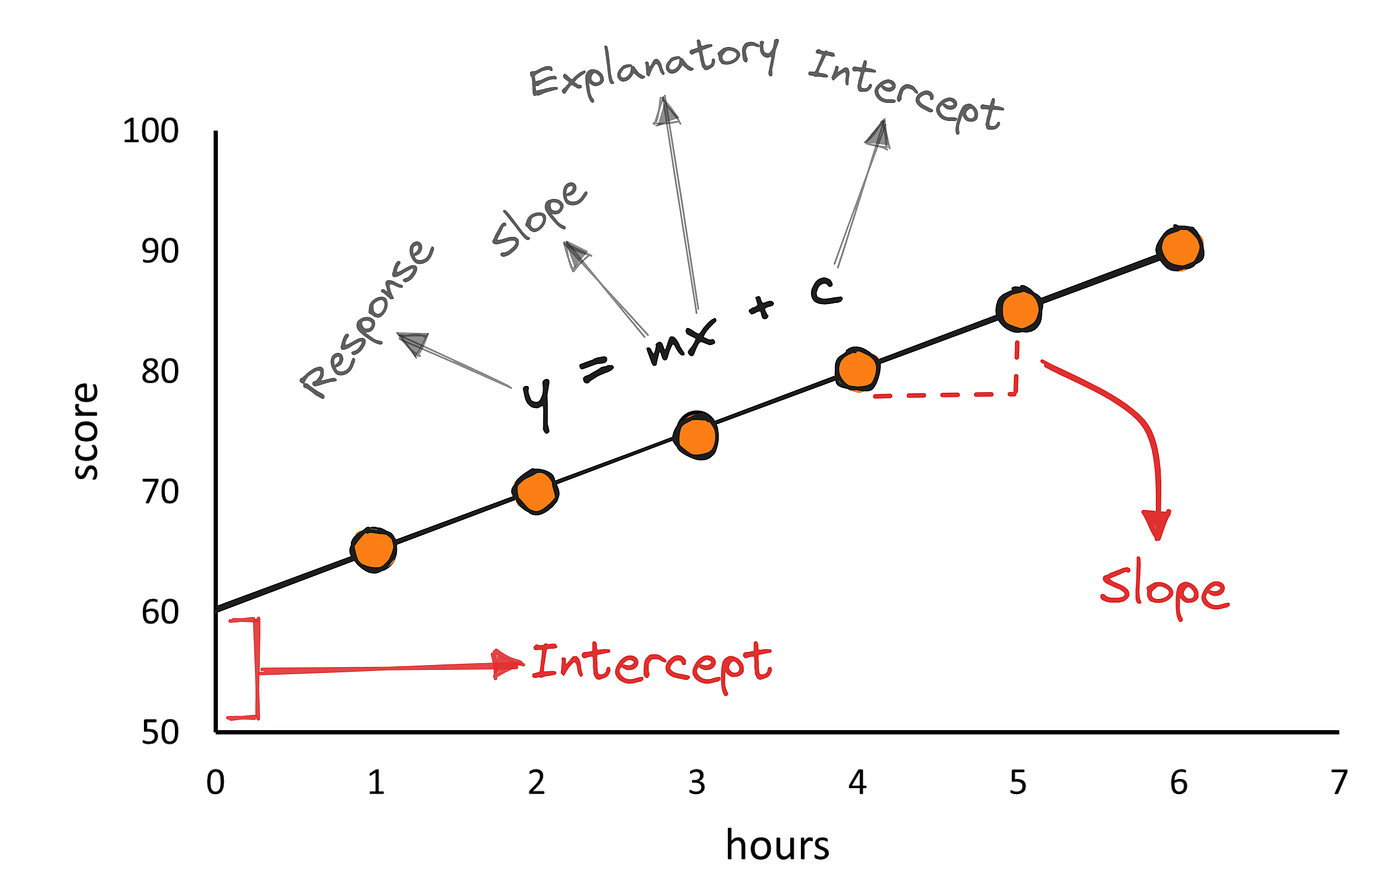

In [1]:
# For handling matrices and dataframes
import numpy as np
import pandas as pd

# sklearn regression models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sb
import plotnine as gg

In [2]:
# Read CSV file
db = pd.read_csv('./archive/car_data.csv', sep=",")

In [3]:
# Overview of the first 10 rows of the dataframe
db.head(10)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
5,vitara brezza,2018,9.25,9.83,2071,Diesel,Dealer,Manual,0
6,ciaz,2015,6.75,8.12,18796,Petrol,Dealer,Manual,0
7,s cross,2015,6.50,8.61,33429,Diesel,Dealer,Manual,0
8,ciaz,2016,8.75,8.89,20273,Diesel,Dealer,Manual,0
9,ciaz,2015,7.45,8.92,42367,Diesel,Dealer,Manual,0


In [4]:
# Statistical description of the dataframe
db.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [5]:
# Using skimpy library to have a "pretty" dashboard-like overview
try:
    import skimpy
    print("skimpy is loaded")
except ImportError as e:
    print("skimpy is not available. Downloading..")
    !pip install skimpy

skimpy is loaded


In [6]:
from skimpy import skim
skim(db)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 301    │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 9      │ │ int32       │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0    ┃ p25    ┃ p50    ┃ p75    ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ Year             │   0 │      0 │    2000 │     2.9 │  2000 │   2000 │   2000 │   2000 │    2000 │   ▂▃▇▅  │  │
│ │ Selling_Price    │   0 │      0 │     4.7 │     5.1 │   0.1 │    0.9 │    3.6 │      6 │      35 │   ▇▂    │  │
│ │ Present_Price    │   0 │      0 │     7.6 │     8.6 │  0.32 │    1.2 │    6.4 │    9.9 │      93 │   ▇▁    │  │
│ │ Kms_Driven       │   0 │      0 │   37000 │   39000 │   500 │  15000 │  32000 │  49000 │  500000 │    ▇    │  │
│ │ Owner            │   0 │      0 │   0.043 │    0.25 │     0 │      0 │      0 │      0 │       3 │    ▇    │  │
│ └──────────────────┴─────┴────────┴─────────┴─────────┴───────┴────────┴────────┴────────┴─────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA     ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Car_Name                   │      0 │          0 │                            2 │                      592 │  │
│ │ Fuel_Type                  │      0 │          0 │                            1 │                      301 │  │
│ │ Seller_Type                │      0 │          0 │                            1 │                      301 │  │
│ │ Transmission               │      0 │          0 │                            1 │                      301 │  │
│ └────────────────────────────┴────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

## Feature subset selection

In [10]:
db['Car_Name'].nunique()

98

##### The dataset has 98 different Car names, which is larger than the number of samples we have. From a data standpoint, it is better to remove the column Car_Name.

In [11]:
db.drop('Car_Name',axis=1,inplace=True)

## Feature transformation

In [12]:
# Transforming the car's manufacturing year to car's age
db['Age'] = 2024 - db['Year']
db.drop('Year',axis=1,inplace=True)

In [13]:
db.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,10
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,11
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,7
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,13
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,10


## Conducting Explanatory Data Analysis

In [8]:
# Columns description
db.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')

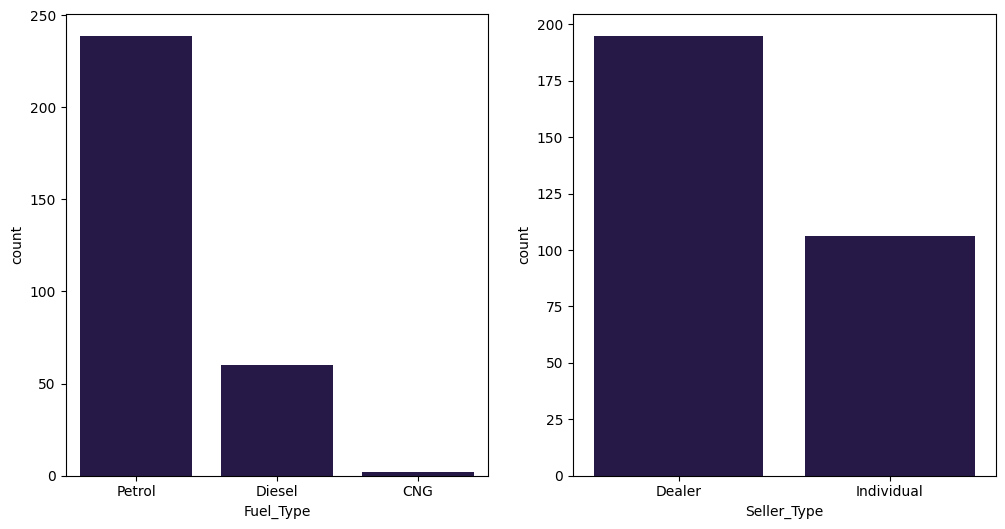

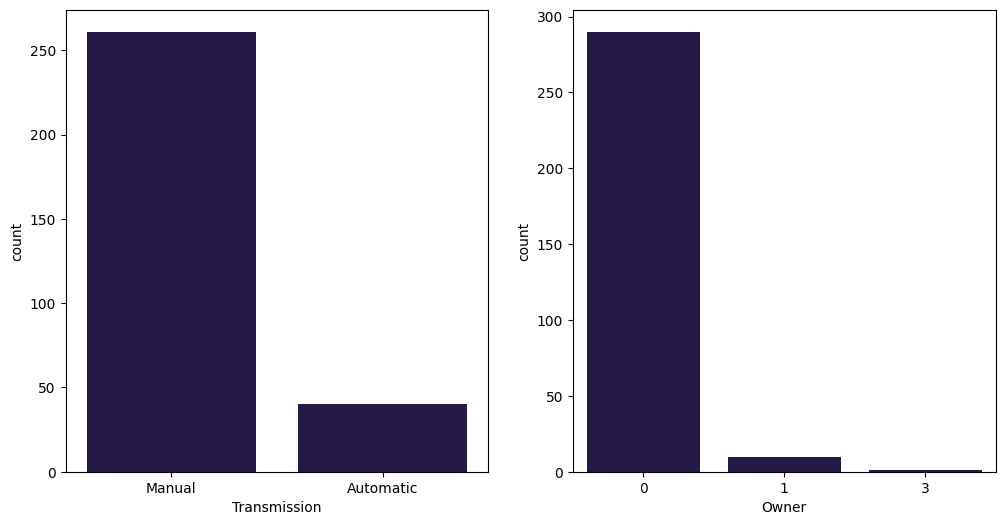

In [9]:
# Analysing categorical (non-numeric) fields
categorical_columns = ['Fuel_Type','Seller_Type','Transmission','Owner']

i = 0
sb.set_palette("magma")

while i < 4:

    fig = plt.figure(figsize=[12,6])
    
    plt.subplot(1,2,1)
    sb.countplot(x=categorical_columns[i],data=db, )
    i += 1

    plt.subplot(1,2,2)
    sb.countplot(x=categorical_columns[i],data=db)
    i += 1

    plt.show()

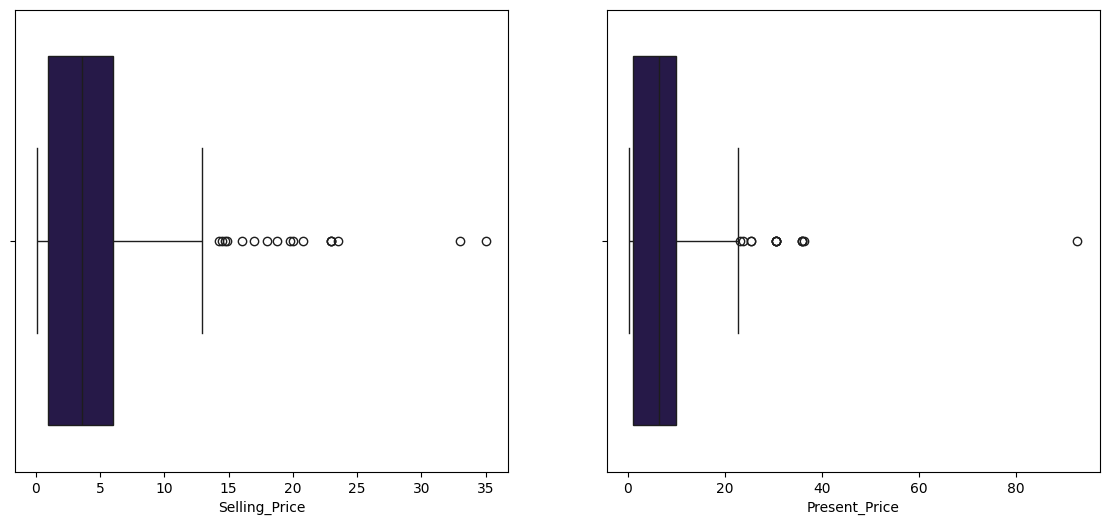

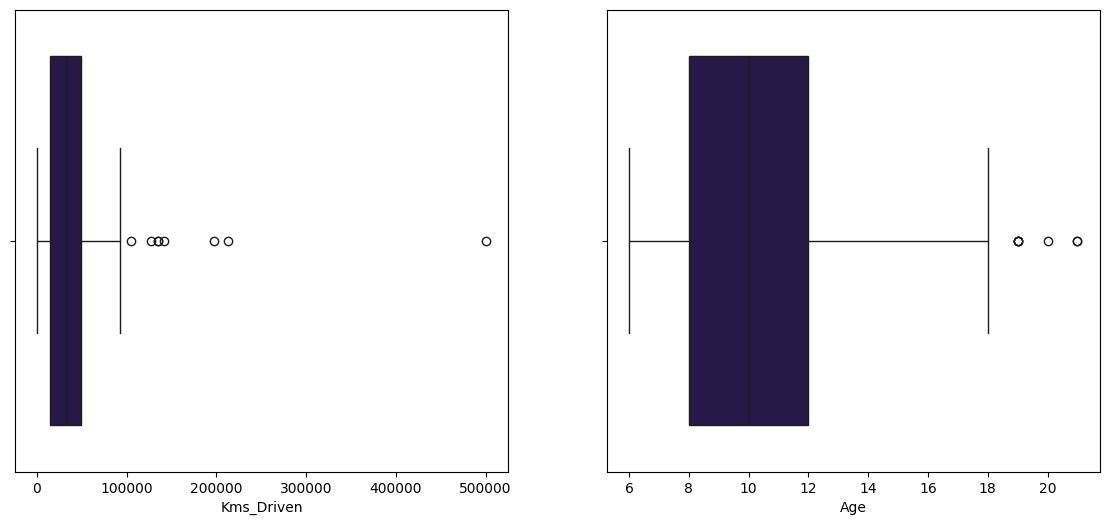

In [16]:
# Detecting Outliers for numerical features
numerical_columns = ['Selling_Price','Present_Price','Kms_Driven','Age']

i = 0
sb.set_palette("magma")

while i < 4:

    fig = plt.figure(figsize=[14,6])

    plt.subplot(1,2,1)
    sb.boxplot(x=numerical_columns[i],data=db)
    i += 1

    plt.subplot(1,2,2)
    sb.boxplot(x=numerical_columns[i],data=db)
    i += 1

    plt.show()

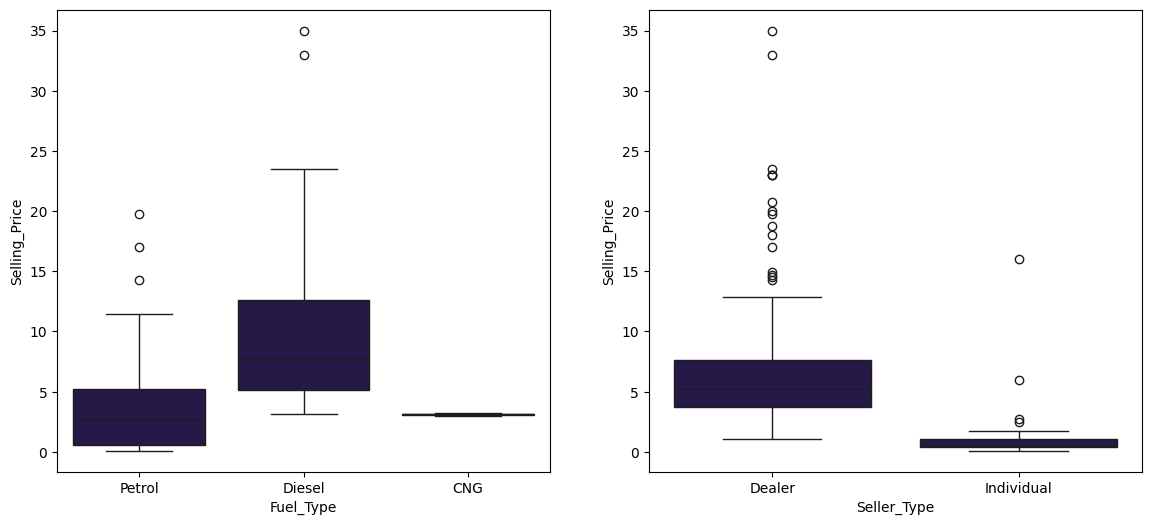

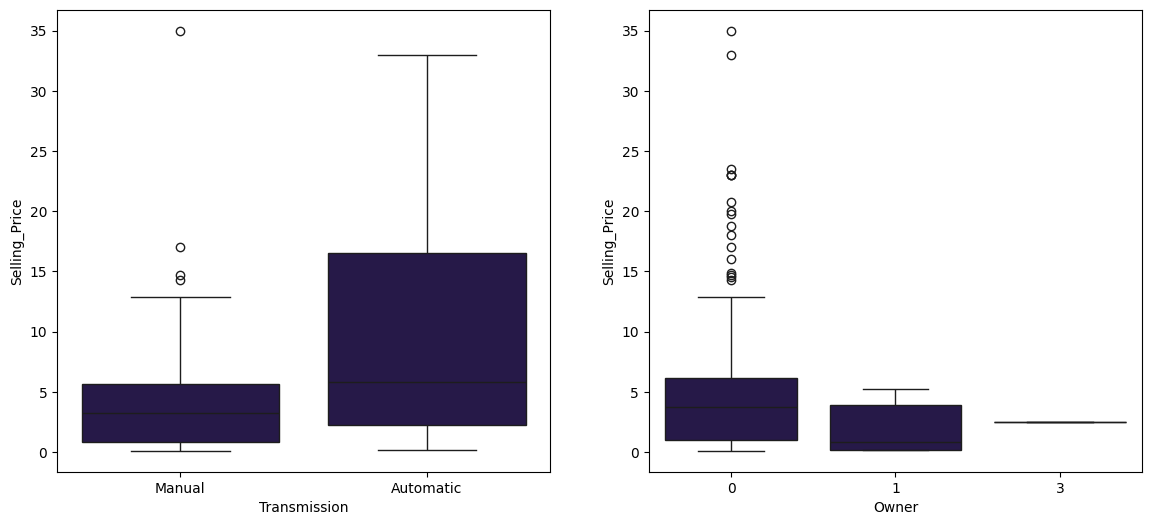

In [20]:
# Detecting Outliers for categorical features
categorical_columns = ['Fuel_Type','Seller_Type','Transmission','Owner']

i = 0
sb.set_palette("magma")

while i < 4:

    fig = plt.figure(figsize=[14,6])

    plt.subplot(1,2,1)
    sb.boxplot(x=categorical_columns[i],data=db,y='Selling_Price')
    i += 1

    plt.subplot(1,2,2)
    sb.boxplot(x=categorical_columns[i],data=db,y='Selling_Price')
    i += 1

    plt.show()

##### The plots above show that several outliers are present in our dataset, especially in the Selling_Price Feature. Lets detect and filter (or not) these outliers using the IQR mrthod.

In [32]:
outliers = []
numerical_columns = ['Selling_Price','Present_Price','Kms_Driven','Age']
categorical_columns = ['Fuel_Type','Seller_Type','Transmission','Owner']

for i in numerical_columns:
    Q1 = db[i].quantile(0.25)
    Q3 = db[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers.extend(db[(db[i] < lower_bound) | (db[i] > upper_bound)].index.tolist())

for i in categorical_columns:
    for cat in db[i].unique():
        db1 = db[db[i] == cat]
        Q1 = db1['Selling_Price'].quantile(0.25)
        Q3 = db1['Selling_Price'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        outliers.extend(db1[(db1['Selling_Price'] < lower_bound) | (db1['Selling_Price'] > upper_bound)].index.tolist())

print('{} The indices of outliers in the dataset are:\n\n{}'.format(len(outliers), outliers))

92 The indices of outliers in the dataset are:

[50, 51, 52, 53, 59, 62, 63, 64, 66, 69, 79, 80, 82, 86, 93, 96, 97, 50, 51, 53, 59, 62, 63, 64, 66, 79, 82, 85, 86, 93, 96, 37, 50, 53, 77, 84, 85, 179, 196, 37, 39, 54, 77, 84, 92, 189, 66, 69, 97, 64, 86, 50, 51, 52, 59, 62, 63, 64, 66, 69, 79, 80, 82, 86, 93, 96, 97, 27, 53, 54, 85, 69, 80, 86, 97, 50, 51, 52, 53, 59, 62, 63, 64, 66, 69, 79, 80, 82, 86, 93, 96, 97]
